In [4]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [5]:
def get_class_names_from_one_hot(encoded_labels, class_names):
    return [class_names[label] for label in np.argmax(encoded_labels, axis=1)]


In [6]:
datadir = '/Users/kesavreddy/Downloads/DataJPG'


In [7]:
category_dirs = [d for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]

# Create a DataFrame with category counts
category_counts = pd.DataFrame({'Category': category_dirs, 'Count': [len(os.listdir(os.path.join(datadir, d))) for d in category_dirs]})

# Display the category counts
print(category_counts)

  Category  Count
0        G     28
1        A    127
2        E      3
3        B     18


In [8]:
img_size = 224
batch_size = 32
num_classes = len(category_dirs)

# Create training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datadir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datadir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)


Found 42526 files belonging to 4 classes.
Using 34021 files for training.


2023-11-15 02:32:03.273010: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-15 02:32:03.273049: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-15 02:32:03.273057: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-15 02:32:03.273331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-15 02:32:03.273360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 42526 files belonging to 4 classes.
Using 8505 files for validation.


In [12]:
# Get the true class labels from the training dataset
true_labels = []
for _, labels in train_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

# Calculate class weights based on class distribution
class_counts = np.bincount(true_labels)
total_samples = len(true_labels)
class_weights = total_samples / (len(class_counts) * class_counts)

class_weights_dict = dict(enumerate(class_weights))


In [13]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [14]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights_dict  # Pass the computed class weights
)


Epoch 1/15


2023-11-15 02:35:57.836127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - ETA: 0s - loss: 2.6541 - accuracy: 0.3930

2023-11-15 02:39:03.556896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - 235s 218ms/step - loss: 2.6541 - accuracy: 0.3930 - val_loss: 1.2127 - val_accuracy: 0.5541 - lr: 0.0010
Epoch 2/15
1064/1064 [==============================] - 202s 190ms/step - loss: 1.7822 - accuracy: 0.4447 - val_loss: 1.7292 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 3/15
1064/1064 [==============================] - 147s 138ms/step - loss: 1.3267 - accuracy: 0.4788 - val_loss: 0.6109 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 4/15
1064/1064 [==============================] - 147s 138ms/step - loss: 1.2784 - accuracy: 0.5022 - val_loss: 1.0890 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 5/15
1064/1064 [==============================] - 147s 139ms/step - loss: 1.2440 - accuracy: 0.5146 - val_loss: 0.6696 - val_accuracy: 0.7571 - lr: 0.0010
Epoch 6/15
1064/1064 [==============================] - 148s 139ms/step - loss: 1.1578 - accuracy: 0.5342 - val_loss: 1.0488 - val_accuracy: 0.5732 - lr: 0.0010
Epoch 7/15
1064/1064 [=======================

In [15]:
test_loss, test_acc = model.evaluate(val_ds)
print("Test accuracy:", test_acc)


266/266 [==============================] - 30s 110ms/step - loss: 0.6109 - accuracy: 0.7393
Test accuracy: 0.7393298149108887


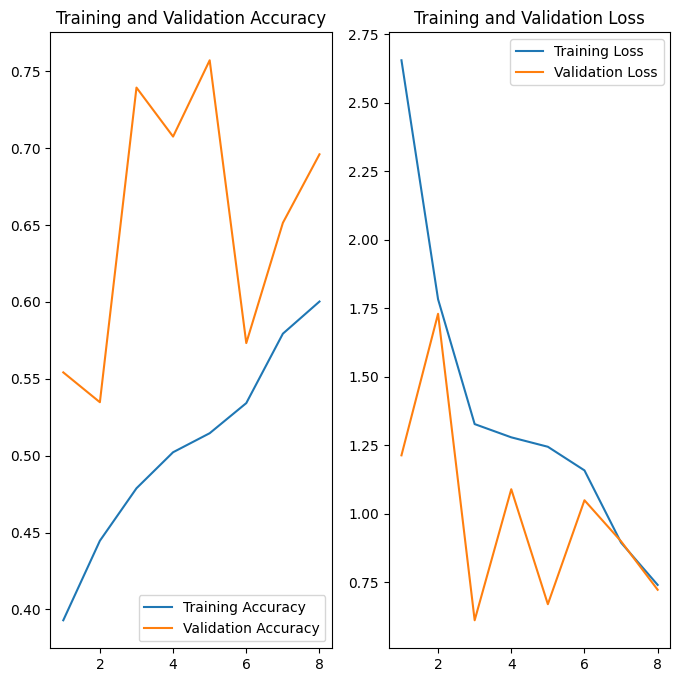

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [18]:
y_true = []
y_pred = []

# Iterate through the training dataset and collect true and predicted labels
for x, y in train_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

# Map class indices to class names
train_y_true_class_names = get_class_names_from_one_hot(tf.keras.utils.to_categorical(y_true, num_classes), category_dirs)
train_y_pred_class_names = get_class_names_from_one_hot(tf.keras.utils.to_categorical(y_pred, num_classes), category_dirs)

# Print the predicted and true class names for each example in the training set
for i in range(len(train_y_pred_class_names)):
    print(f"Predicted: {train_y_pred_class_names[i]}, Actual: {train_y_true_class_names[i]}")

1/1 [==============================] - 0s 39ms/step
Predicted: A, Actual: A
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: B
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: B
Predicted: G, Actual: B
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: B
Predicted: E, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: B
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: A, Actual: G
Predicted: G, Actual: B
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: B
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: B
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: B, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: G, Actual: G
Predicted: B

In [19]:
train_accuracy = accuracy_score(train_y_true, train_y_pred)
train_recall = recall_score(train_y_true, train_y_pred, average='weighted')
train_precision = precision_score(train_y_true, train_y_pred, average='weighted', zero_division=0)
train_f1 = f1_score(train_y_true, train_y_pred, average='weighted')

print("Training Accuracy:", train_accuracy)
print("Training Recall:", train_recall)
print("Training Precision:", train_precision)
print("Training F1 Score:", train_f1)


Training Accuracy: 0.7366038623203316
Training Recall: 0.7366038623203316
Training Precision: 0.7157532058591645
Training F1 Score: 0.6940396798608087


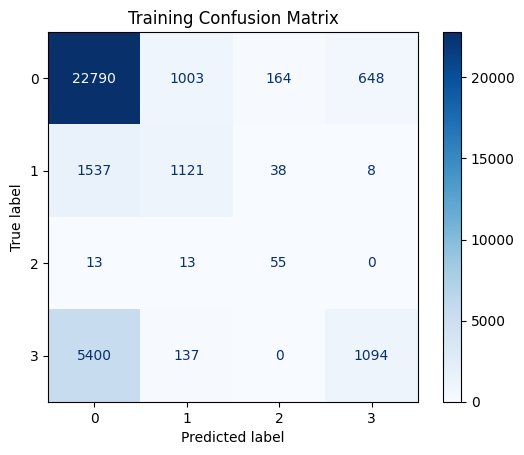

In [20]:
train_cm = confusion_matrix(train_y_true, train_y_pred)

train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
train_disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Training Confusion Matrix")
plt.show()

In [21]:
class_names = {'A': 'Adinocarcinoma', 'B': 'Small Cell carcinoma', 'E': 'Large Cell Carcinoma', 'G': 'Squamous Cell Carcinoma'}

# Print the predicted and true class names for each example in the training set
for i in range(len(train_y_pred_class_names)):
    predicted_class_name = class_names[train_y_pred_class_names[i]]
    actual_class_name = class_names[train_y_true_class_names[i]]
    print(f"Predicted: {predicted_class_name}, Actual: {actual_class_name}")


Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Small Cell carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Small Cell carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Small Cell carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Small Cell carcinoma
Predicted:

In [22]:
model.save("ResNet50.h5")
print("Model saved successfully.")

/Users/kesavreddy/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.
